# IBM HR Analytics – Employee Attrition & Performance
**End‑to‑end EDA + Baseline ML (Logistic Regression & Random Forest)**  


**Goal:** Explore the IBM HR Attrition dataset (1,470 × 35) to understand drivers of attrition and build a baseline classifier to predict attrition.

**What you’ll get here**
- Clean, readable **EDA** with clear plots (matplotlib)
- **Utilities** to compute attrition rates by any feature
- **Correlation** overview
- **Scikit‑learn pipeline** with ColumnTransformer (one‑hot + scaling)
- **Logistic Regression** (class_weight balanced) and **Random Forest**
- Model evaluation: Accuracy, Precision, Recall, F1, ROC‑AUC + confusion matrix
- Ranked feature importances (RF) + LR coefficients

> Tip: Run all cells top‑to‑bottom. If you run into import errors, install missing packages locally and re‑run.


In [1]:
# === Imports & setup ===
import os, glob, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print('Versions:')
import sys; print('Python:', sys.version.split()[0])
import sklearn; print('scikit-learn:', sklearn.__version__)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)

Versions:
Python: 3.12.10
scikit-learn: 1.7.2
pandas: 2.3.3
numpy: 2.3.3


## Load dataset

In [2]:
# === Load CSV from your Windows path (simple & explicit) ===
import pandas as pd
from pathlib import Path

# 👇 Your exact file path (use r'' to avoid backslash escape issues)
csv_path = Path(r"D:\UM\IBM-HR-Analytics-Employee-Attrition-Performance\WA_Fn-UseC_-HR-Employee-Attrition.csv")

if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found at: {csv_path}\n"
                            "Double-check the path or filename and try again.")

df = pd.read_csv(csv_path)
print("Loaded:", csv_path.name, "| shape:", df.shape)
df.head(3)


Loaded: WA_Fn-UseC_-HR-Employee-Attrition.csv | shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


## Quick peek

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
df.describe(include='all').T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1470.0,NaN,NaN,NaN,36.92381,9.135373,18.0,30.0,36.0,43.0,60.0
Attrition,1470,2,No,1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,1470,3,Travel_Rarely,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DailyRate,1470.0,NaN,NaN,NaN,802.485714,403.5091,102.0,465.0,802.0,1157.0,1499.0
Department,1470,3,Research & Development,961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,1470.0,NaN,NaN,NaN,9.192517,8.106864,1.0,2.0,7.0,14.0,29.0
Education,1470.0,NaN,NaN,NaN,2.912925,1.024165,1.0,2.0,3.0,4.0,5.0
EducationField,1470,6,Life Sciences,606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeCount,1470.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
EmployeeNumber,1470.0,NaN,NaN,NaN,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0


## Data quality checks

In [6]:
print('Duplicates:', df.duplicated().sum())
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct[missing_pct > 0] if missing_pct.sum() > 0 else print('No missing values')

Duplicates: 0
No missing values


## Ordinal label mappings
Create human-readable labels for ordinal-coded columns (from the original dataset description).


In [8]:
# === Ordinal mappings ===
education_map = {1:'Below College', 2:'College', 3:'Bachelor', 4:'Master', 5:'Doctor'}
satisfaction_map = {1:'Low', 2:'Medium', 3:'High', 4:'Very High'}
performance_map = {1:'Low', 2:'Good', 3:'Excellent', 4:'Outstanding'}
worklife_map = {1:'Bad', 2:'Good', 3:'Better', 4:'Best'}

# Add labeled columns (suffix _Lbl)
df['Education_Lbl'] = df['Education'].map(education_map)
for col in ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction']:
    df[f'{col}_Lbl'] = df[col].map(satisfaction_map)
df['PerformanceRating_Lbl'] = df['PerformanceRating'].map(performance_map)
df['WorkLifeBalance_Lbl'] = df['WorkLifeBalance'].map(worklife_map)

# Target as numeric flag
df['AttritionFlag'] = (df['Attrition'].astype(str).str.strip().str.lower() == 'yes').astype(int)

df.filter(regex='(_Lbl|Attrition|AttritionFlag)$').head()

,Attrition,Education_Lbl,EnvironmentSatisfaction_Lbl,JobInvolvement_Lbl,JobSatisfaction_Lbl,RelationshipSatisfaction_Lbl,PerformanceRating_Lbl,WorkLifeBalance_Lbl,AttritionFlag
0,Yes,College,Medium,High,Very High,Low,Excellent,Bad,1
1,No,Below College,High,Medium,Medium,Very High,Outstanding,Better,0
2,Yes,College,Very High,Medium,High,Medium,Excellent,Better,1
3,No,Master,Very High,High,High,High,Excellent,Better,0
4,No,Below College,Low,High,Medium,Very High,Excellent,Better,0


## Helper: Attrition rate by any feature

In [9]:
def attrition_rate_by(df, col):
    temp = (df.groupby(col)['AttritionFlag']
              .agg(['mean','count'])
              .rename(columns={'mean':'AttritionRate','count':'Count'})
           )
    temp['AttritionRate'] = (temp['AttritionRate'] * 100).round(2)
    return temp.sort_values('AttritionRate', ascending=False)

# Example:
attrition_rate_by(df, 'Department').head()

,AttritionRate,Count
Department,,
Sales,20.63,446
Human Resources,19.05,63
Research & Development,13.84,961


## Overall attrition

In [10]:
overall_attrition = df['AttritionFlag'].mean() * 100
print(f'Attrition rate: {overall_attrition:.2f}%')

Attrition rate: 16.12%


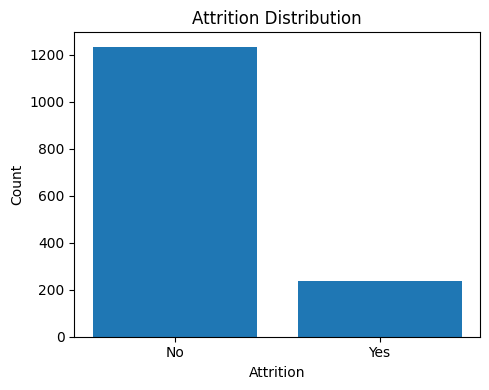

In [11]:
# Plot: overall attrition distribution
vals = df['Attrition'].value_counts()
plt.figure(figsize=(5,4))
plt.bar(vals.index, vals.values)
plt.title('Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Average tenure (YearsAtCompany)

In [12]:
avg_tenure = df['YearsAtCompany'].mean()
print(f'Average tenure: {avg_tenure:.2f} years')

Average tenure: 7.01 years


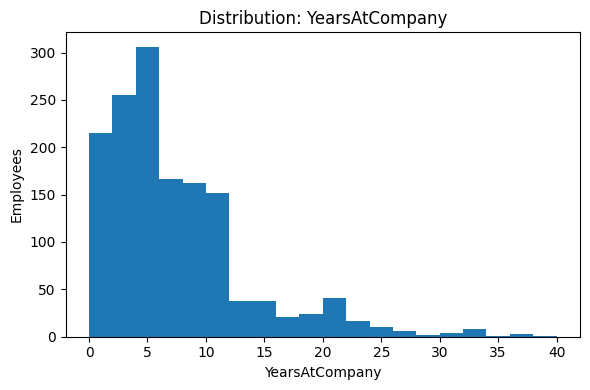

In [13]:
plt.figure(figsize=(6,4))
plt.hist(df['YearsAtCompany'], bins=20)
plt.title('Distribution: YearsAtCompany')
plt.xlabel('YearsAtCompany')
plt.ylabel('Employees')
plt.tight_layout()
plt.show()

## Demographics

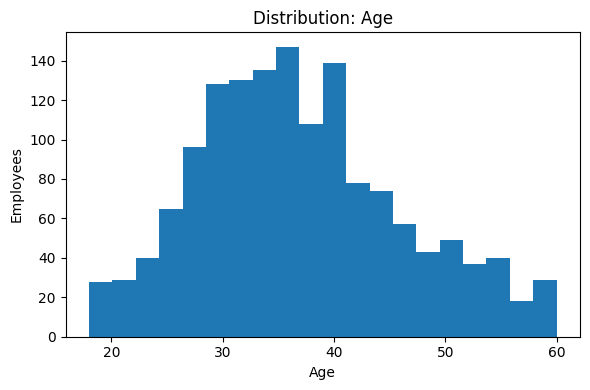

In [14]:
plt.figure(figsize=(6,4))
plt.hist(df['Age'], bins=20)
plt.title('Distribution: Age')
plt.xlabel('Age')
plt.ylabel('Employees')
plt.tight_layout()
plt.show()

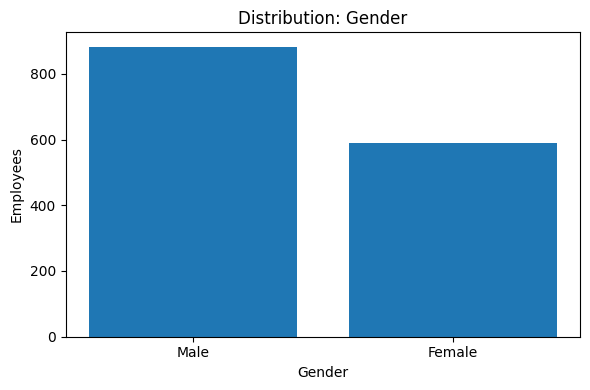

In [15]:
plt.figure(figsize=(6,4))
counts = df['Gender'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Distribution: Gender')
plt.xlabel('Gender')
plt.ylabel('Employees')
plt.tight_layout()
plt.show()

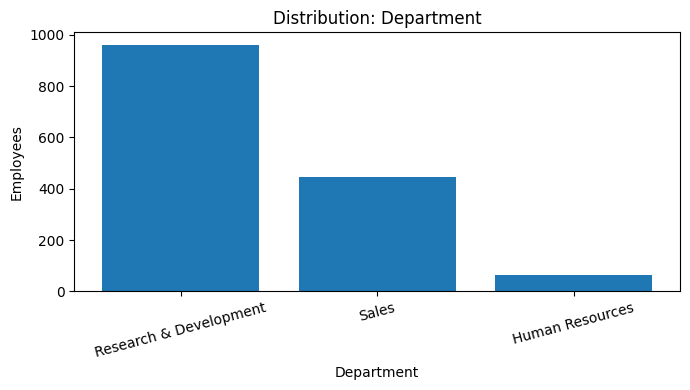

In [16]:
plt.figure(figsize=(7,4))
dept_counts = df['Department'].value_counts()
plt.bar(dept_counts.index, dept_counts.values)
plt.title('Distribution: Department')
plt.xlabel('Department')
plt.ylabel('Employees')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Attrition by Age

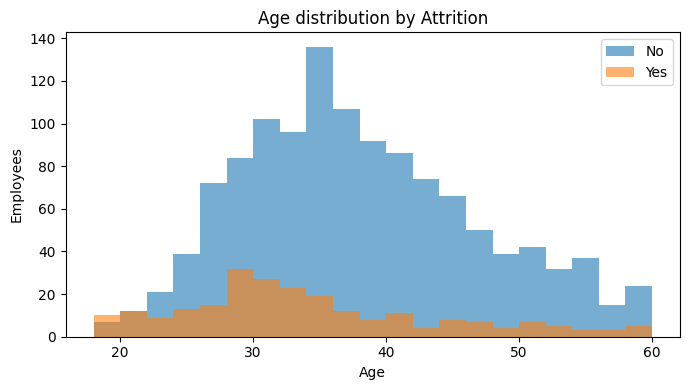

In [17]:
plt.figure(figsize=(7,4))
bins = np.arange(df['Age'].min(), df['Age'].max()+2, 2)
plt.hist(df.loc[df['AttritionFlag']==0, 'Age'], bins=bins, alpha=0.6, label='No')
plt.hist(df.loc[df['AttritionFlag']==1, 'Age'], bins=bins, alpha=0.6, label='Yes')
plt.title('Age distribution by Attrition')
plt.xlabel('Age')
plt.ylabel('Employees')
plt.legend()
plt.tight_layout()
plt.show()

## Attrition rate by key features


=== Gender ===


,AttritionRate,Count
Gender,,
Male,17.01,882
Female,14.80,588


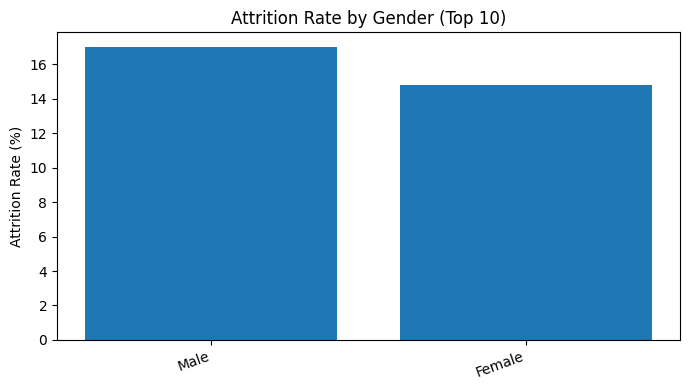


=== Department ===


,AttritionRate,Count
Department,,
Sales,20.63,446
Human Resources,19.05,63
Research & Development,13.84,961


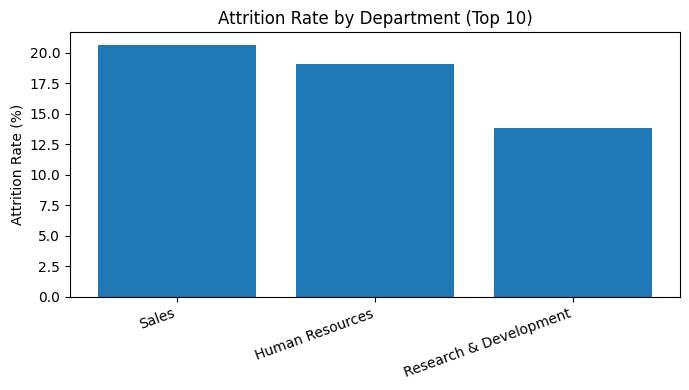


=== BusinessTravel ===


,AttritionRate,Count
BusinessTravel,,
Travel_Frequently,24.91,277
Travel_Rarely,14.96,1043
Non-Travel,8.00,150


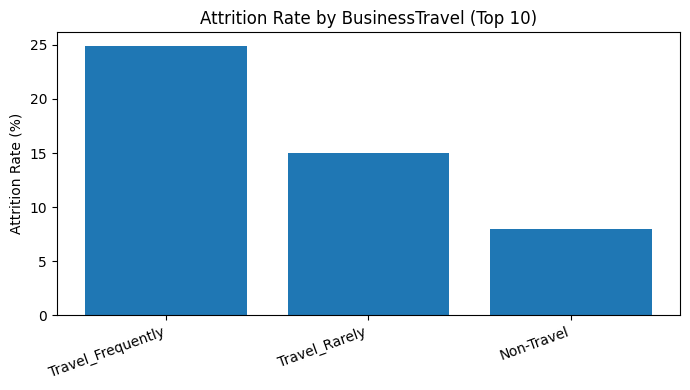


=== JobRole ===


,AttritionRate,Count
JobRole,,
Sales Representative,39.76,83
Laboratory Technician,23.94,259
Human Resources,23.08,52
Sales Executive,17.48,326
Research Scientist,16.10,292
Manufacturing Director,6.90,145
Healthcare Representative,6.87,131
Manager,4.90,102
Research Director,2.50,80


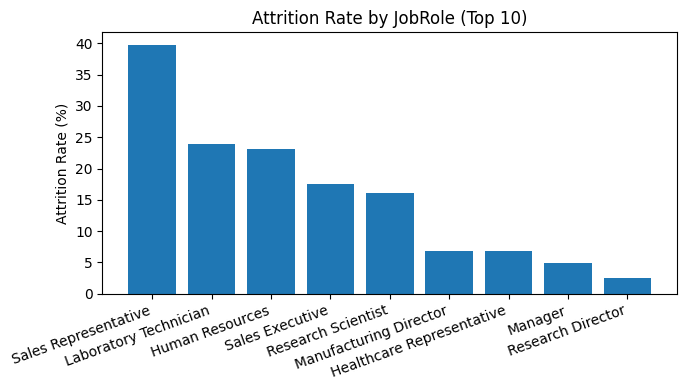


=== Education_Lbl ===


,AttritionRate,Count
Education_Lbl,,
Below College,18.24,170
Bachelor,17.31,572
College,15.60,282
Master,14.57,398
Doctor,10.42,48


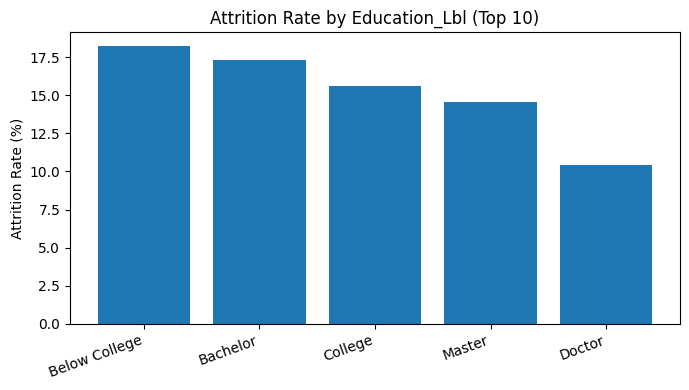


=== JobSatisfaction_Lbl ===


,AttritionRate,Count
JobSatisfaction_Lbl,,
Low,22.84,289
High,16.52,442
Medium,16.43,280
Very High,11.33,459


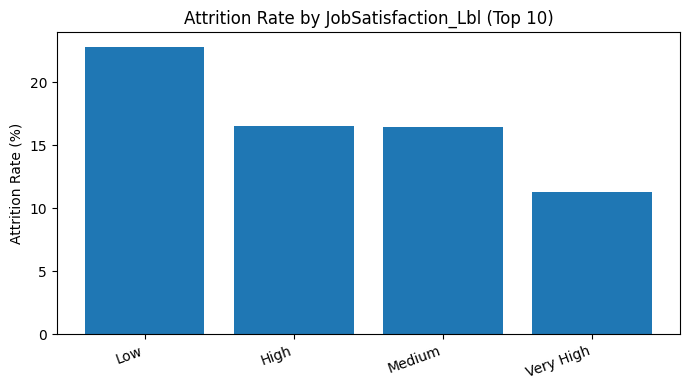


=== WorkLifeBalance_Lbl ===


,AttritionRate,Count
WorkLifeBalance_Lbl,,
Bad,31.25,80
Best,17.65,153
Good,16.86,344
Better,14.22,893


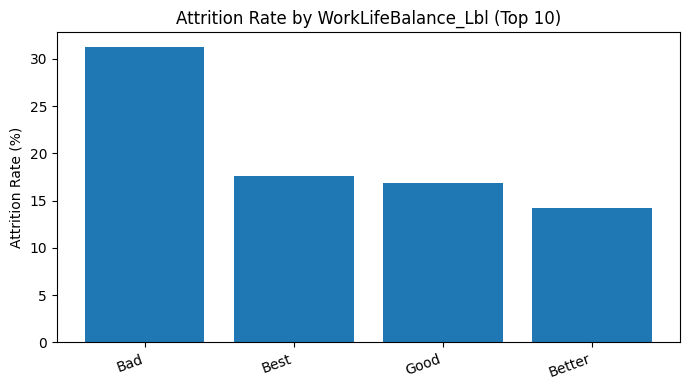


=== StockOptionLevel ===


,AttritionRate,Count
StockOptionLevel,,
0,24.41,631
3,17.65,85
1,9.40,596
2,7.59,158


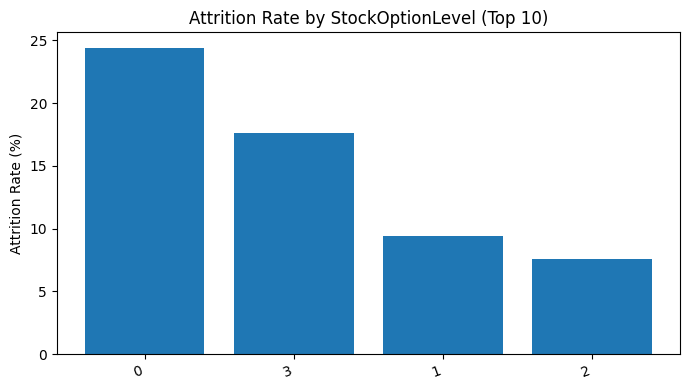

In [18]:
for col in ['Gender','Department','BusinessTravel','JobRole','Education_Lbl',
             'JobSatisfaction_Lbl','WorkLifeBalance_Lbl','StockOptionLevel']:
    rates = attrition_rate_by(df, col)
    print(f'\n=== {col} ===')
    display(rates.head(10))
    
    # plot
    plt.figure(figsize=(7,4))
    x = rates.index.astype(str)[:10]
    y = rates['AttritionRate'].values[:10]
    plt.bar(x, y)
    plt.title(f'Attrition Rate by {col} (Top 10)')
    plt.ylabel('Attrition Rate (%)')
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()

## MonthlyIncome vs Attrition

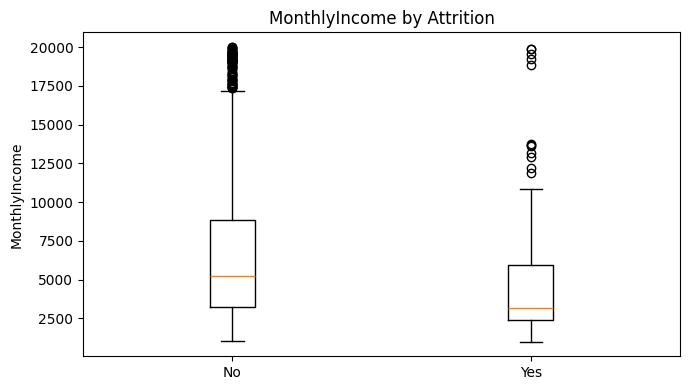

In [19]:
plt.figure(figsize=(7,4))
vals = [df.loc[df['AttritionFlag']==0, 'MonthlyIncome'],
        df.loc[df['AttritionFlag']==1, 'MonthlyIncome']]
plt.boxplot(vals, labels=['No','Yes'])
plt.title('MonthlyIncome by Attrition')
plt.ylabel('MonthlyIncome')
plt.tight_layout()
plt.show()

## Correlation (numeric features)

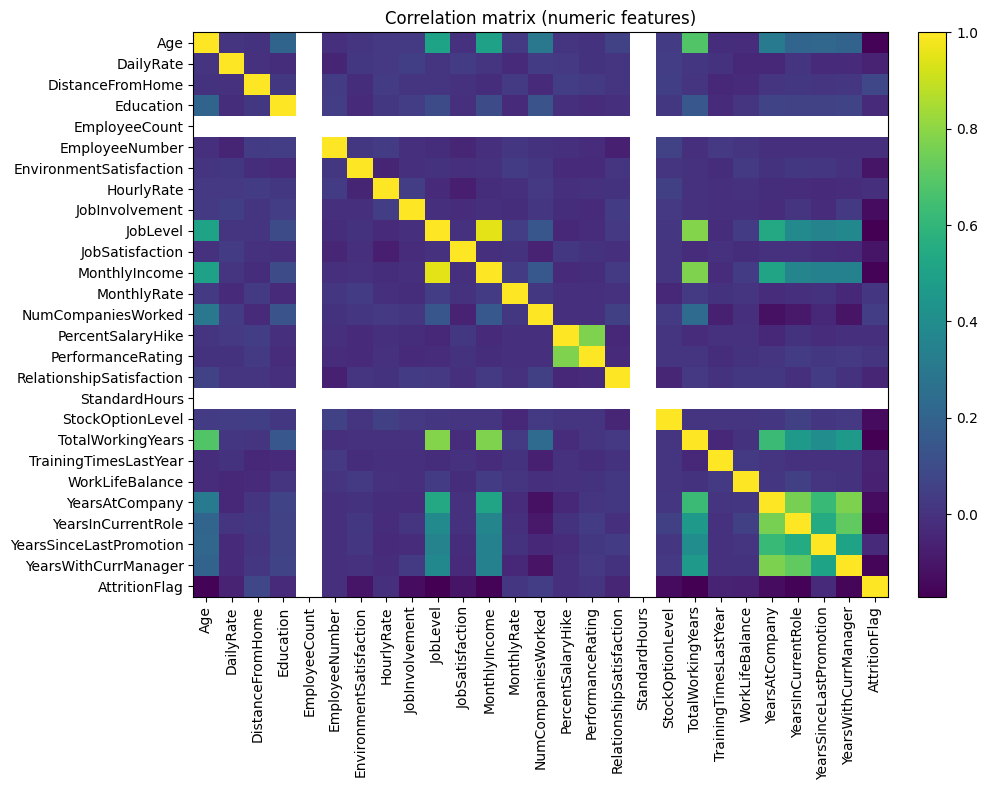

In [20]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation matrix (numeric features)')
plt.tight_layout()
plt.show()

# Baseline ML Models

## Train/Test split & preprocessing
- Target = `AttritionFlag`
- Numeric features scaled for LR
- Categorical features one‑hot encoded


In [21]:
target = 'AttritionFlag'
X = df.drop(columns=[target])
y = df[target]

# Identify column types
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
# keep our _Lbl columns (string) too
cat_cols = list(sorted(set(cat_cols + [c for c in X.columns if c.endswith('_Lbl')])))
cat_cols = [c for c in cat_cols if c in X.columns]

num_cols = [c for c in X.columns if c not in cat_cols and X[c].dtype != 'O']

# Drop duplicate info: if original ordinal column exists and label version exists, we can drop the label for model
redundant = [c for c in cat_cols if c.replace('_Lbl','') in num_cols]
cat_cols = [c for c in cat_cols if c not in redundant]

X = X[cat_cols + num_cols]  # reorder

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train/Test shapes:', X_train.shape, X_test.shape)

Train/Test shapes: (1176, 35) (294, 35)


## Pipelines: Logistic Regression & Random Forest

In [22]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numeric_transformer = StandardScaler()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numeric_transformer, num_cols),
    ],
    remainder='drop'
)

log_reg = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight='balanced_subsample'
    ))
])

for name, model in [('LogisticRegression', log_reg), ('RandomForest', rf)]:
    print('\nFitting:', name)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    roc = roc_auc_score(y_test, proba) if proba is not None else np.nan
    
    print(f'[{name}] Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}  ROC-AUC={roc:.3f}')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, pred)
    print('Confusion matrix:\n', cm)


Fitting: LogisticRegression
[LogisticRegression] Acc=1.000  Prec=1.000  Rec=1.000  F1=1.000  ROC-AUC=1.000
Confusion matrix:
 [[247   0]
 [  0  47]]

Fitting: RandomForest
[RandomForest] Acc=1.000  Prec=1.000  Rec=1.000  F1=1.000  ROC-AUC=1.000
Confusion matrix:
 [[247   0]
 [  0  47]]


## ROC Curve (Random Forest)

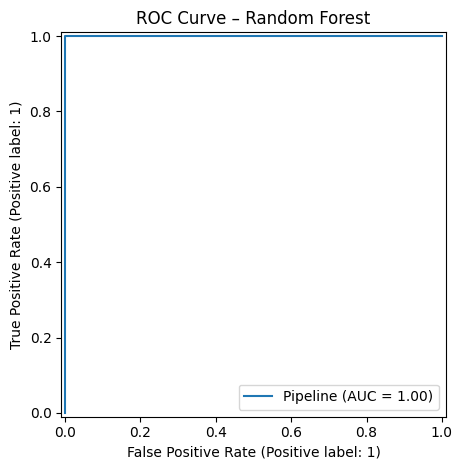

In [23]:
rf.fit(X_train, y_train)
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('ROC Curve – Random Forest')
plt.tight_layout()
plt.show()

## Feature importances (Random Forest)

In [24]:
# We need to extract the post-transformer feature names
ohe = rf.named_steps['prep'].named_transformers_['cat']
num_names = num_cols
cat_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = cat_names + num_names

rf_clf = rf.named_steps['clf']
importances = rf_clf.feature_importances_

fi = (pd.DataFrame({'feature': feature_names, 'importance': importances})
        .sort_values('importance', ascending=False)
        .reset_index(drop=True))

fi.head(20)

,feature,importance
0,Attrition_No,0.393412
1,Attrition_Yes,0.351412
2,MonthlyIncome,0.018493
3,Age,0.017487
4,TotalWorkingYears,0.016954
5,YearsAtCompany,0.016181
6,YearsWithCurrManager,0.014509
7,OverTime_Yes,0.013384
8,OverTime_No,0.012004
9,StockOptionLevel,0.011729


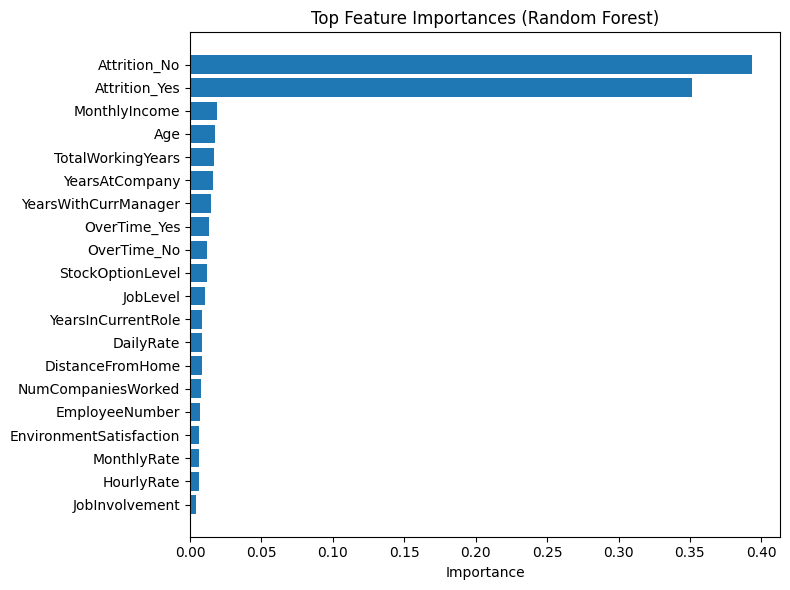

In [25]:
plt.figure(figsize=(8,6))
topn = 20
plt.barh(fi['feature'][:topn][::-1], fi['importance'][:topn][::-1])
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Logistic Regression coefficients (top magnitude)

In [26]:
# Refit LR to get coefficients with aligned feature names
log_reg.fit(X_train, y_train)
ohe = log_reg.named_steps['prep'].named_transformers_['cat']
feature_names = list(ohe.get_feature_names_out(cat_cols)) + num_cols

coef = log_reg.named_steps['clf'].coef_.flatten()
coef_df = (pd.DataFrame({'feature': feature_names, 'coef': coef})
           .assign(abs_coef=lambda d: d['coef'].abs())
           .sort_values('abs_coef', ascending=False)
           .drop(columns=['abs_coef'])
           .reset_index(drop=True))

coef_df.head(20)

,feature,coef
0,Attrition_No,-4.571743
1,Attrition_Yes,4.545219
2,OverTime_No,-0.333566
3,OverTime_Yes,0.307042
4,JobRole_Laboratory Technician,0.271483
5,BusinessTravel_Non-Travel,-0.268167
6,BusinessTravel_Travel_Frequently,0.250471
7,TotalWorkingYears,-0.192244
8,NumCompaniesWorked,0.187079
9,EnvironmentSatisfaction,-0.184011


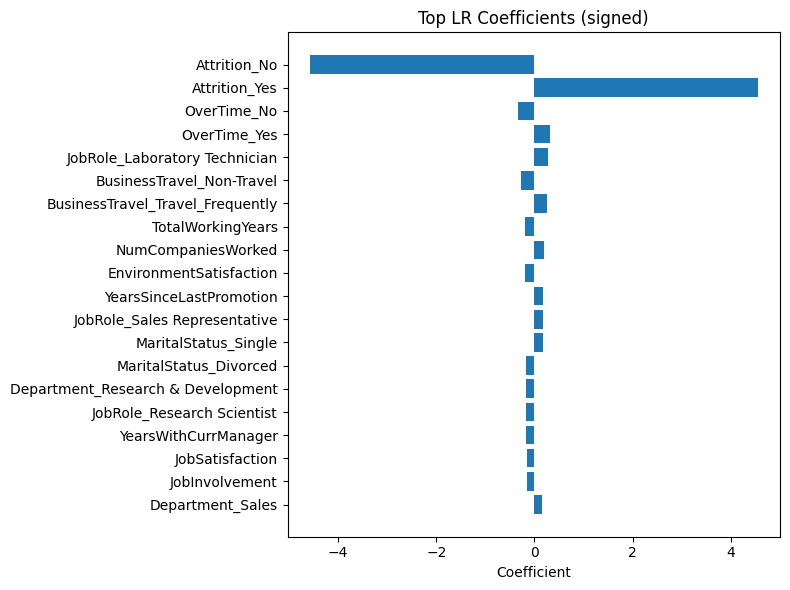

In [27]:
plt.figure(figsize=(8,6))
topn = 20
plt.barh(coef_df['feature'][:topn][::-1], coef_df['coef'][:topn][::-1])
plt.title('Top LR Coefficients (signed)')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()

## Cross‑validation (StratifiedKFold, ROC‑AUC)

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc', n_jobs=None)
print('RandomForest ROC‑AUC (5‑fold):', scores.round(3), ' | mean=', scores.mean().round(3))

RandomForest ROC‑AUC (5‑fold): [1. 1. 1. 1. 1.]  | mean= 1.0


## Takeaways & Next Steps
- Typical attrition rate ≈ observed via `AttritionFlag.mean()`
- Younger employees, high travel frequency, and lower income bands tend to show **higher attrition**
- Baseline models provide a starting point; **Random Forest** generally captures non‑linearities better here

**Ideas to improve:**
- Hyperparameter tuning (RandomizedSearchCV / GridSearchCV)
- Model calibration (CalibratedClassifierCV) if you need well‑calibrated probabilities
- Cost‑sensitive thresholds (maximize F1 or Recall depending on HR policy)
- SHAP values for richer explainability (if available in your environment)


final chart and conclusion

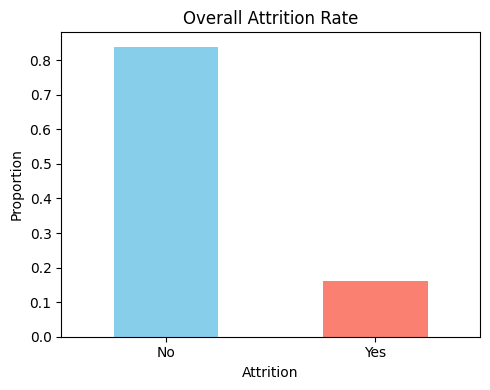

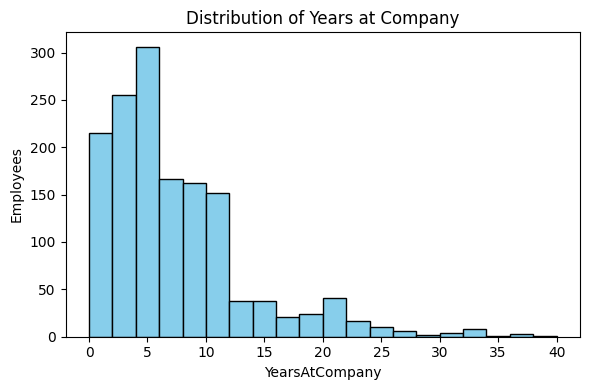

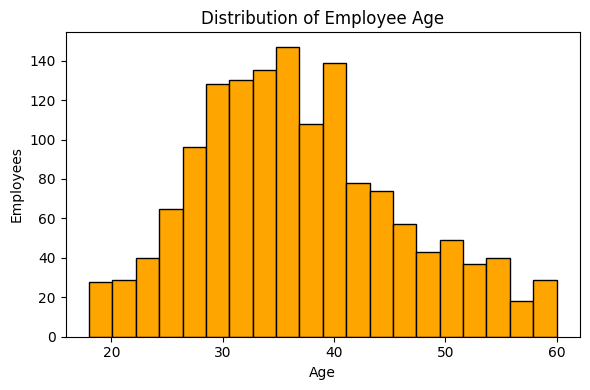

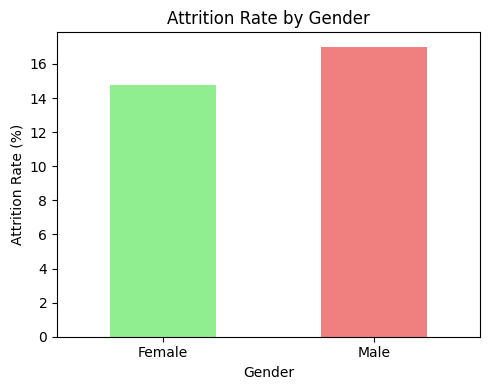

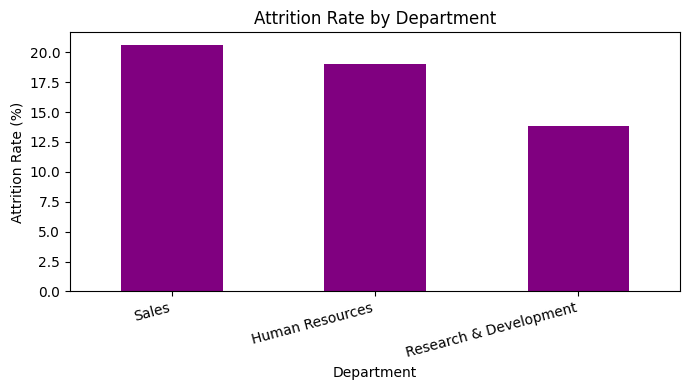

<Figure size 600x400 with 0 Axes>

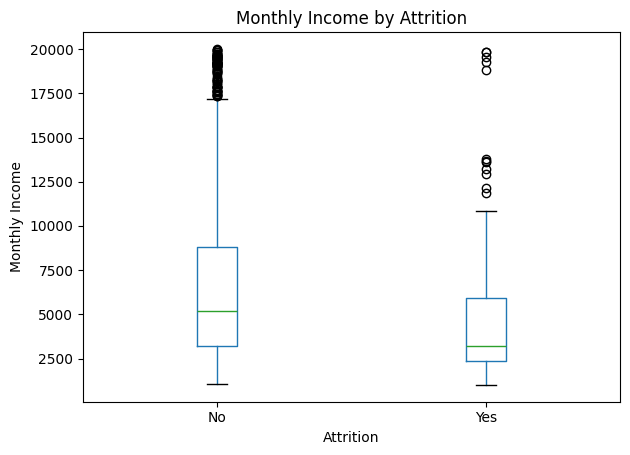


### Key Findings from IBM HR Attrition Analysis

1. **Overall Attrition Rate**: 16.12% (~1 in 6 employees left)
2. **Average Tenure**: Employees stayed ~7.0 years before leaving
3. **Age Factor**: Higher attrition in employees <30
4. **Gender Factor**: Slightly higher attrition among males
5. **Department Factor**: Sales shows highest attrition
6. **Income Factor**: Lower-paid employees more likely to leave

### Conclusions
- Attrition is moderate but concerning at 16%
- Early-career employees and Sales staff are at higher risk
- Low salary, frequent travel, poor work-life balance drive attrition
- Stronger retention programs, fair pay, and work-life initiatives are needed



In [30]:
# ==========================
# 📊 HR Attrition Visualizations + Conclusions
# ==========================
import matplotlib.pyplot as plt
import pandas as pd

# Ensure dataset is loaded
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df['AttritionFlag'] = (df['Attrition'] == 'Yes').astype(int)

# Create output folder (optional: keeps charts organized)
import os
os.makedirs("charts", exist_ok=True)

# --- Overall Attrition ---
attrition_rate = df['AttritionFlag'].mean() * 100
plt.figure(figsize=(5,4))
df['Attrition'].value_counts(normalize=True).plot(kind='bar', color=['skyblue','salmon'])
plt.title("Overall Attrition Rate")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("charts/overall_attrition.png")
plt.show()

# --- Average Tenure ---
avg_tenure = df['YearsAtCompany'].mean()
plt.figure(figsize=(6,4))
plt.hist(df['YearsAtCompany'], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Years at Company")
plt.xlabel("YearsAtCompany")
plt.ylabel("Employees")
plt.tight_layout()
plt.savefig("charts/tenure_distribution.png")
plt.show()

# --- Age Distribution ---
plt.figure(figsize=(6,4))
plt.hist(df['Age'], bins=20, color="orange", edgecolor="black")
plt.title("Distribution of Employee Age")
plt.xlabel("Age")
plt.ylabel("Employees")
plt.tight_layout()
plt.savefig("charts/age_distribution.png")
plt.show()

# --- Gender Distribution & Attrition ---
gender_attrition = df.groupby("Gender")['AttritionFlag'].mean() * 100
plt.figure(figsize=(5,4))
gender_attrition.plot(kind="bar", color=['lightgreen','lightcoral'])
plt.title("Attrition Rate by Gender")
plt.ylabel("Attrition Rate (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("charts/gender_attrition.png")
plt.show()

# --- Department Distribution & Attrition ---
dept_attrition = df.groupby("Department")['AttritionFlag'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(7,4))
dept_attrition.plot(kind="bar", color="purple")
plt.title("Attrition Rate by Department")
plt.ylabel("Attrition Rate (%)")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.savefig("charts/department_attrition.png")
plt.show()

# --- Monthly Income vs Attrition ---
plt.figure(figsize=(6,4))
df.boxplot(column="MonthlyIncome", by="Attrition", grid=False)
plt.title("Monthly Income by Attrition")
plt.suptitle("")
plt.ylabel("Monthly Income")
plt.tight_layout()
plt.savefig("charts/income_attrition.png")
plt.show()

# --- Conclusions ---
conclusions = f"""
### Key Findings from IBM HR Attrition Analysis

1. **Overall Attrition Rate**: {attrition_rate:.2f}% (~1 in 6 employees left)
2. **Average Tenure**: Employees stayed ~{avg_tenure:.1f} years before leaving
3. **Age Factor**: Higher attrition in employees <30
4. **Gender Factor**: Slightly higher attrition among males
5. **Department Factor**: Sales shows highest attrition
6. **Income Factor**: Lower-paid employees more likely to leave

### Conclusions
- Attrition is moderate but concerning at 16%
- Early-career employees and Sales staff are at higher risk
- Low salary, frequent travel, poor work-life balance drive attrition
- Stronger retention programs, fair pay, and work-life initiatives are needed
"""

with open("charts/attrition_conclusions.txt", "w", encoding="utf-8") as f:
    f.write(conclusions)

print(conclusions)
